# 用v1的model对v2预测 看下效果 是否能去掉错误标注？

In [4]:
import sys
root = '/home/featurize/data'
sys.path.append(f'{root}/pikachu/utils')
sys.path.append(f'{root}/pikachu/third')
sys.path.append(f'{root}/pikachu')
sys.path.append(f'{root}/pikachu/projects/ai/naic_seg')

In [5]:
import os
import gezi
from gezi import tqdm
import melt as mt
import numpy as np
import cv2
import glob
import tensorflow as tf

In [6]:
# model = mt.load_model('/home/featurize/work/naicseg/v7/ensemble.gpu3/model.h5')
model_path = '/home/featurize/work/naicseg/v8.dv1/sm.Unet.EfficientNetB4/model.h5'
model = mt.load_model(model_path)

In [7]:
model_path2 = '/home/featurize/work/naicseg/v9/sm.Unet.EfficientNetB4.augl3.200epoch/model.h5'
model2 = mt.load_model(model_path2)

In [8]:
model_path3 = '/home/featurize/data/submit/model.h5'
model3 = mt.load_model(model_path3)

In [9]:
model.summary()

Model: "sm.Unet_EfficientNetB4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_ReverseV2 (TensorFl (None, 256, 256, 3)  0           image[0][0]                      
__________________________________________________________________________________________________
tf_op_layer_ReverseV2_1 (Tensor (None, 256, 256, 3)  0           image[0][0]                      
__________________________________________________________________________________________________
tf_op_layer_RealDiv_2 (TensorFl (None, 256, 256, 3)  0           image[0][0]                      
_____________________________________________________________________________

In [10]:
model2.summary()

Model: "sm.Unet_EfficientNetB4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_ResizeBilinear (Ten (None, 288, 288, 3)  0           image[0][0]                      
__________________________________________________________________________________________________
tf_op_layer_Reshape (TensorFlow (None, 288, 288, 3)  0           tf_op_layer_ResizeBilinear[0][0] 
__________________________________________________________________________________________________
tf_op_layer_ReverseV2 (TensorFl (None, 288, 288, 3)  0           tf_op_layer_Reshape[0][0]        
_____________________________________________________________________________

In [11]:
model3.summary()

Model: "Ensemble.2.sm.FPN.EfficientNetB4.augl3.200epoch_sm.Unet.EfficientNetB4.augl3.size256.200epoch"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, None, None,  0                                            
__________________________________________________________________________________________________
sm.FPN_EfficientNetB4_0 (Functi (None, None, None, 1 20932839    image[0][0]                      
__________________________________________________________________________________________________
sm.Unet_EfficientNetB4_1 (Funct (None, None, None, 1 23092895    image[0][0]                      
__________________________________________________________________________________________________
tf_op_layer_stack (TensorFlowOp (None, 2, None, None 0           sm.FPN_EfficientNetB4_0[0][0]    
      

In [14]:
img = gezi.imread('../input/eval.naic.v1/image/187676.tif')

In [15]:
CLASSES = ['water', 'track', 'build', 'arable', 'grass', 'forest', 'bare', 'other']
CLASSES_V2 = ['water', 'track_road', 'build', 'track_airport', 'other_park', 'other_playground', 
            'arable_natural', 'arable_greenhouse',
            'grass_natural', 'grass_greenbelt', 
            'forest_natural', 'forest_planted', 
            'bare_natural', 'bare_planted', 'other_other']

In [16]:
def vis_pred_dv1(x, index, root_dir='../input/eval.naic.v1'):
  label = (cv2.imread(f'{root_dir}/label/{index}.png', cv2.IMREAD_UNCHANGED) / 100 - 1).astype(np.uint8)
  gezi.plot.segmentation_eval_logits(
            cv2.imread(f'{root_dir}/image/{index}.tif'),
            label,
            x,
            CLASSES,
        )

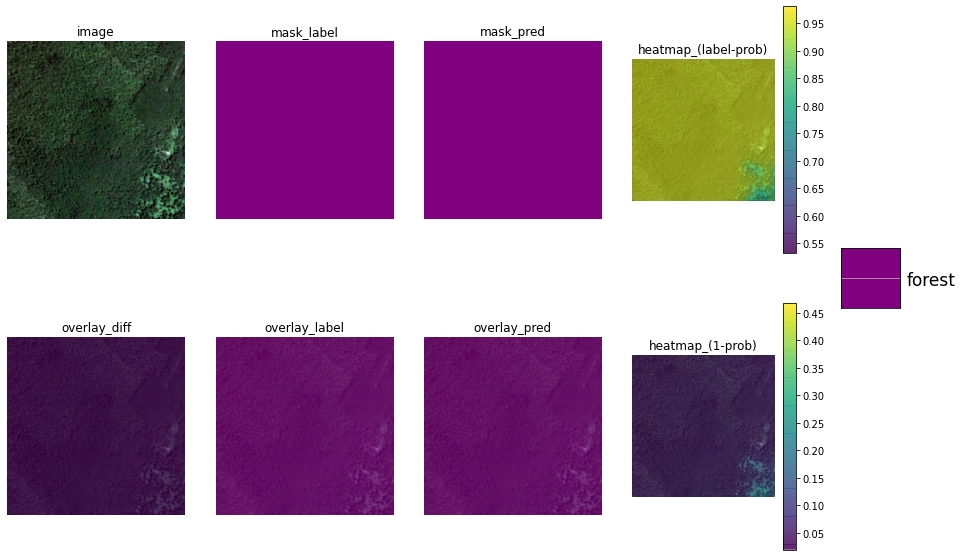

In [17]:
index = 121116
img = gezi.imread(f'../input/eval.naic.v1/image/{index}.tif')
res = model.predict(np.asarray([img]))[0]
vis_pred_dv1(res, index)

In [18]:
m2 = {
  0: 0,
  1: 1,
  2: 2,
  3: 1,
  4: 7,
  5: 7,
  6: 3,
  7: 3,
  8: 4,
  9: 4,
  10: 5,
  11: 5,
  12: 6,
  13: 6,
  14: 7,
}
m = {}
for i in range(17):
  if i < 4:
    m[i + 1] = i
  else:
    m[i + 1] = i - 2

def vis_pred_dv2(x, index, root_dir='../input/eval.naic'):
  label = (cv2.imread(f'{root_dir}/label/{index}.png', cv2.IMREAD_UNCHANGED)).astype(np.uint8)
  f = np.vectorize(lambda x: m[x])
  label = f(label).astype(np.uint8)
  f = np.vectorize(lambda x: m2[x])
  label = f(label).astype(np.uint8)
  gezi.plot.segmentation_eval_logits(
            cv2.imread(f'{root_dir}/image/{index}.tif'),
            label,
            x,
            CLASSES,
        )

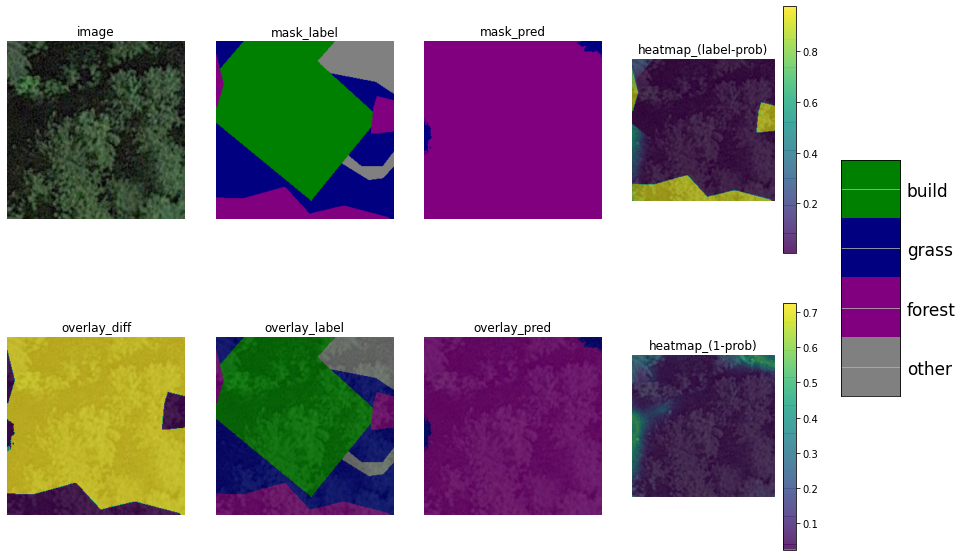

In [36]:
index = 8534
img = gezi.imread(f'../input/eval.naic/image/{index}.tif')
res = model.predict(np.asarray([img]))[0]
vis_pred_dv2(res, index)

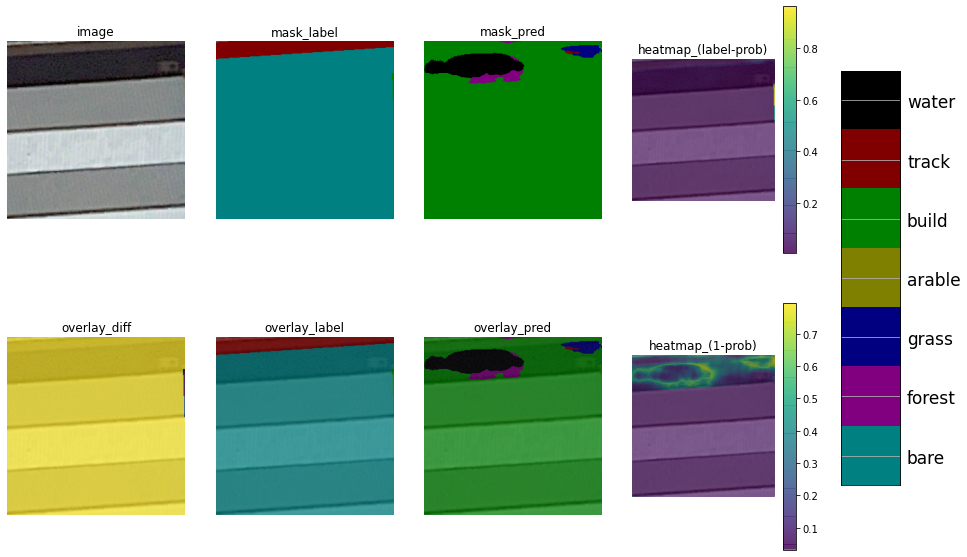

In [41]:
index = 14714
img = gezi.imread(f'../input/eval.naic/image/{index}.tif')
res = model.predict(np.asarray([img]))[0]
vis_pred_dv2(res, index)

In [21]:
def predicts(model, indir='../input/eval.naic/image', odir='../input/out.v1inferv2', batch_size=16):
  gezi.try_mkdir(odir)
  img_paths = glob.glob(f'{indir}/*')
  num_imgs = len(img_paths)
  for i in tqdm(range(0, num_imgs, batch_size), desc='predict', ascii=True, leave=True):
    begin = i
    end = min(i + batch_size, num_imgs)
    imgs = np.asarray([gezi.imread(img_path) for img_path in img_paths[begin:end]])
    logits = model.predict(imgs)
    preds = logits.argmax(-1)
    for img_path, pred in zip(img_paths[begin:end], preds):
      index = os.path.basename(img_path).split('.')[0]
      cv2.imwrite(os.path.join(odir, f'{index}.png'), pred)

In [22]:
def vis_pred_v2(x, index, root_dir='../input/eval.naic'):
  label = (cv2.imread(f'{root_dir}/label/{index}.png', cv2.IMREAD_UNCHANGED)).astype(np.uint8)
  m = {}
  for i in range(17):
    if i < 4:
      m[i + 1] = i
    else:
      m[i + 1] = i - 2
  f = np.vectorize(lambda x: m[x])
  label = f(label).astype(np.uint8)
  gezi.plot.segmentation_eval_logits(
            cv2.imread(f'{root_dir}/image/{index}.tif'),
            label,
            x,
            CLASSES_V2,
        )

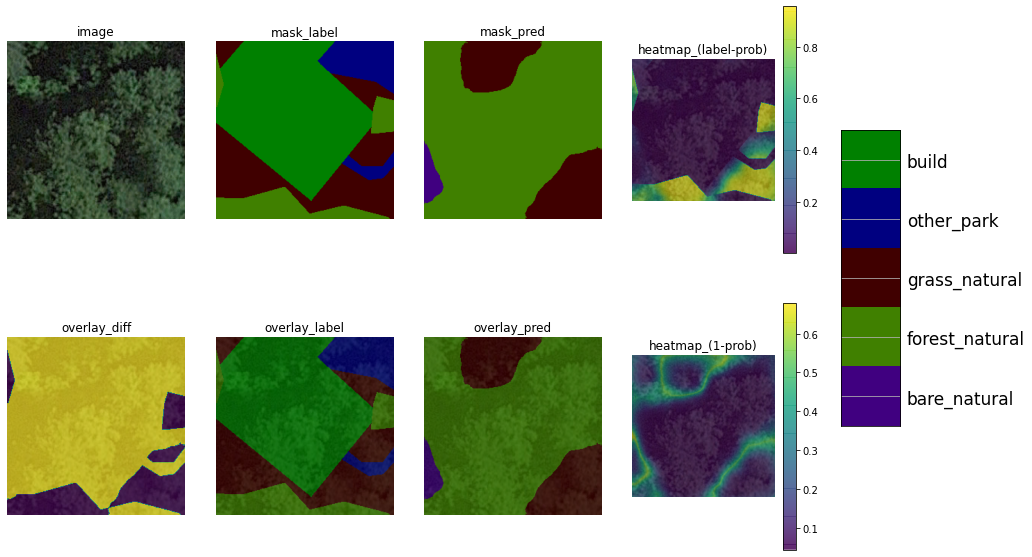

In [37]:
index = 8534
img = gezi.imread(f'../input/eval.naic/image/{index}.tif')
res = model2.predict(np.asarray([img]))[0]
vis_pred_v2(res, index)

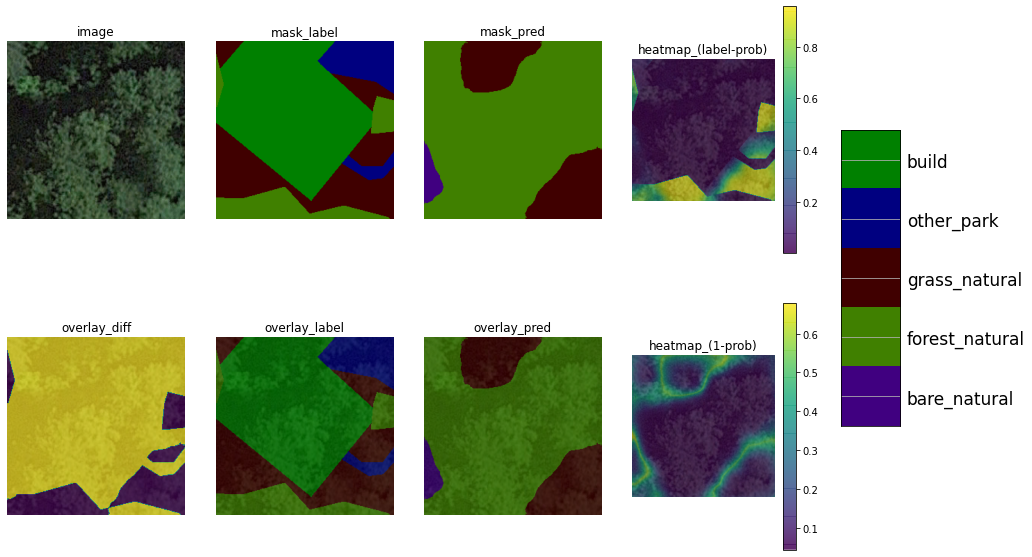

In [28]:
index = 8534
img = gezi.imread(f'../input/eval.naic/image/{index}.tif')
res = model2.predict(np.asarray([img]))[0]
vis_pred_v2(res, index)

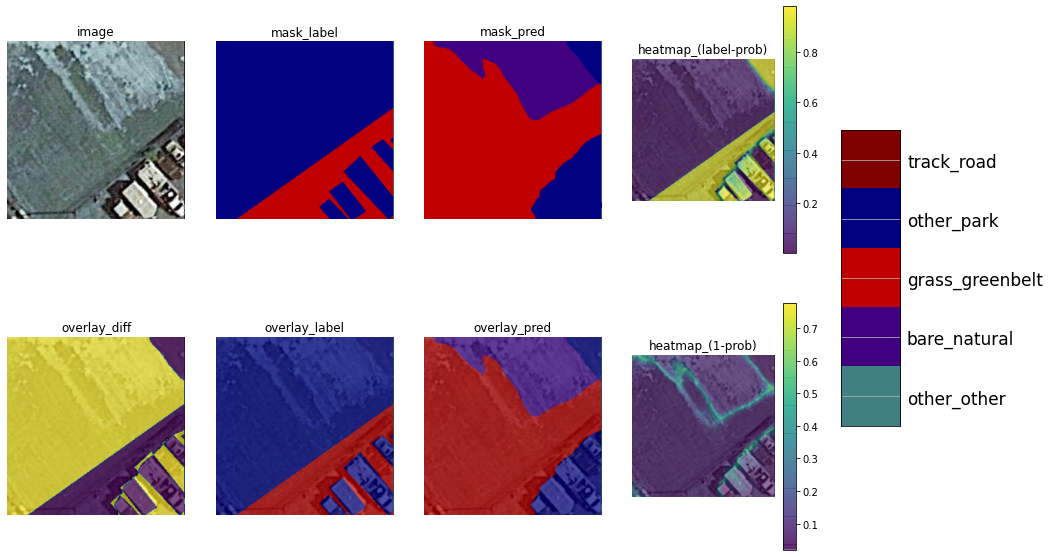

In [38]:
index = 18896
img = gezi.imread(f'../input/eval.naic/image/{index}.tif')
res = model3.predict(np.asarray([img]))[0]
vis_pred_v2(res, index)